In [3]:
import pandas as pd
import yfinance as yf
import mplfinance as mf
import numpy as np
import matplotlib.pyplot as plt

today = pd.Timestamp('today')
xle = yf.download( 'XLE',
                        start = '2020-01-01',
                        end = today,
                        progress = False)


In [4]:
xle.describe()


,Open,High,Low,Close,Adj Close,Volume
count,320.000000,320.000000,320.000000,320.000000,320.000000,3.200000e+02
mean,40.292000,40.860187,39.589656,40.218469,38.702890,3.127481e+07
std,8.500194,8.405774,8.531964,8.468701,7.992826,1.305648e+07
min,24.330000,25.290001,22.879999,23.570000,22.246618,8.224500e+06
25%,34.927500,35.562500,33.677500,34.384999,32.983226,2.252118e+07
50%,38.285000,38.699999,37.715000,38.195000,36.848249,2.930585e+07
75%,45.535000,46.330000,44.985001,45.337501,43.909121,3.805610e+07
max,61.130001,61.310001,60.400002,60.869999,56.470043,9.935670e+07


In [5]:
#Check if any data is missing
xle.isnull().any()


Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

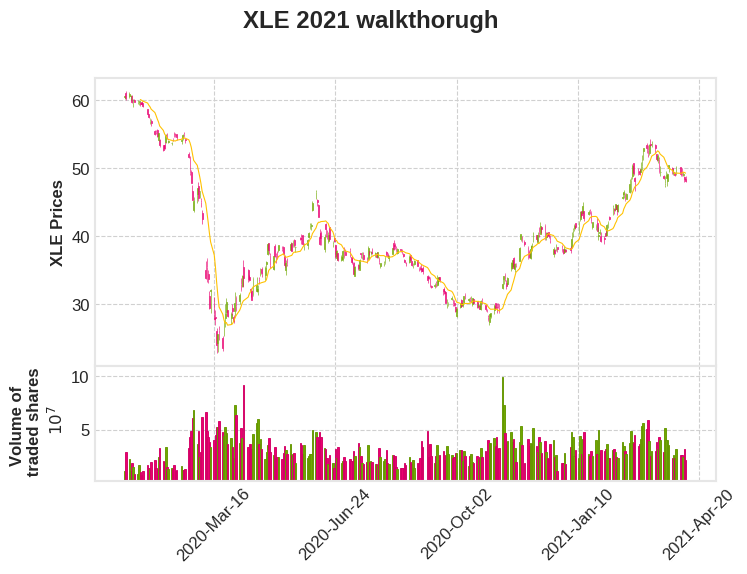

In [6]:
mf.plot(xle, 
        type = 'candle',
        title = 'XLE 2021 walkthorugh',
        style =  'binance',
        ylabel = 'XLE Prices',
        volume = True,
        figratio=(12,8),
        show_nontrading = True,
        ylabel_lower='Volume of \n traded shares',
        mav = 10)

In [7]:
xle.columns = map(str.lower, xle.columns)

In [8]:
print(xle)

                 open       high        low      close  adj close    volume
Date                                                                       
2020-01-02  60.439999  60.669998  60.230000  60.580002  56.201008  11944700
2020-01-03  61.130001  61.310001  60.099998  60.400002  56.034016  29502900
2020-01-06  60.610001  61.180000  60.400002  60.869999  56.470043  22458100
2020-01-07  60.700001  60.770000  60.000000  60.709999  56.321609  11462500
2020-01-08  60.650002  60.720001  59.630001  59.709999  55.393890  19021400
...               ...        ...        ...        ...        ...       ...
2021-04-05  50.209999  50.220001  48.820000  49.110001  49.110001  26686100
2021-04-06  49.349998  50.009998  48.900002  48.980000  48.980000  26628900
2021-04-07  49.000000  49.400002  48.820000  49.150002  49.150002  24944300
2021-04-08  48.799999  48.810001  47.950001  48.509998  48.509998  31883300
2021-04-09  48.500000  48.919998  47.970001  48.189999  48.189999  22177100

[320 rows x

# Calculate MACD

In [9]:
smoothing12 = 2/13
smoothing26 = 2/27
smoothing9 = 2/10

def sma(close_prices,days):
    ma = [0]*len(close_prices)
    for i in range(days,len(close_prices)):
        ma[i] = sum(close_prices[i-days:i])/days
    return ma

def ema(close_prices,sma,smoothing,days):
    emavg = [0]*len(close_prices)
    emavg[days] = sma[days]
    for i in range(days+1,len(close_prices)):
        emavg[i] = (close_prices[i]-emavg[i-1])*smoothing+emavg[i-1]
    return emavg
    
xle['close']

Date
2020-01-02    60.580002
2020-01-03    60.400002
2020-01-06    60.869999
2020-01-07    60.709999
2020-01-08    59.709999
                ...    
2021-04-05    49.110001
2021-04-06    48.980000
2021-04-07    49.150002
2021-04-08    48.509998
2021-04-09    48.189999
Name: close, Length: 320, dtype: float64

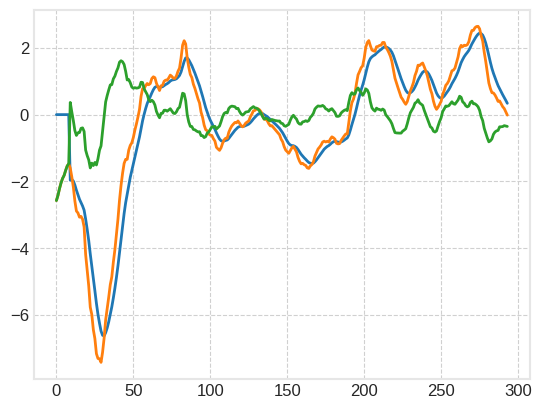

In [10]:
sma12 = sma(xle['close'],12)
sma26 = sma(xle['close'],26)


ema12 = ema(xle['close'],sma12,smoothing12,12)
ema26 = ema(xle['close'],sma26,smoothing26,26)

close = xle['close']
macd = np.subtract(ema12[26:len(ema12)],ema26[26:len(ema26)])

           
macdsma = sma(macd,9)

macdema = ema(macd,macdsma,smoothing9,9)
plt.plot(macdema)
plt.plot(macd)
plt.plot(np.subtract(macd,macdema))
plt.show()



In [11]:
print(ema12[12])

59.99333381652832


In [12]:
len(xle['close'])

320

In [13]:
def derivative(data):
    dx = [0]*(len(data))
    for i in range(1,len(data)-1):
        dx[i] = data[i]-data[i-1]
    return dx



In [14]:
macd_sig_ma = sma(derivative(macd_sig),3)

NameError: name 'macd_sig' is not defined

In [ ]:
plt.plot(macd_sig)
plt.plot(macd_sig_ma)
plt.show()

# Calculate RSI

In [ ]:
def rsi(close_prices,window_length):
    delta = close_prices.diff()
    delta = delta[1:]
    
    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    
    # Calculate the EWMA
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()

    # Calculate the RSI based on EWMA
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))

    # Calculate the SMA
    roll_up2 = up.rolling(window_length).mean()
    roll_down2 = down.abs().rolling(window_length).mean()

    # Calculate the RSI based on SMA
    RS2 = roll_up2 / roll_down2
    RSI2 = 100.0 - (100.0 / (1.0 + RS2))
    
    return RSI2



In [ ]:
RSI = rsi(xle['close'],14)

In [ ]:
plt.plot(RSI[26:len(ema26)])
plt.show()

In [ ]:
plt.plot(macd_sig)
plt.plot(macd_sig_ma)
plt.show()

# TTM Squeeze

https://github.com/hackingthemarkets/ttm-squeeze

In [65]:

import os, pandas
import plotly.graph_objects as go
symbol = 'XLE'
df = yf.download( 'XLE',
                        start = '2021-01-01',
                        end = today,
                        interval = '1h',
                        progress = False)


df['20sma'] = df['Close'].rolling(window=20).mean()
df['stddev'] = df['Close'].rolling(window=20).std()
df['lower_band'] = df['20sma'] - (2 * df['stddev'])
df['upper_band'] = df['20sma'] + (2 * df['stddev'])

df['TR'] = abs(df['High'] - df['Low'])
df['ATR'] = df['TR'].rolling(window=20).mean()

df['lower_keltner'] = df['20sma'] - (df['ATR'] * 1.5)
df['upper_keltner'] = df['20sma'] + (df['ATR'] * 1.5)

def in_squeeze(df):
    return df['lower_band'] > df['lower_keltner'] and df['upper_band'] < df['upper_keltner']

df['squeeze_on'] = df.apply(in_squeeze, axis=1)

if df.iloc[-3]['squeeze_on'] and not df.iloc[-1]['squeeze_on']:
    print("{} is coming out the squeeze".format(symbol))

# save all dataframes to a dictionary
# we can chart individual names below by calling the chart() function
dataframes[symbol] = df


def chart(df):
    candlestick = go.Candlestick(open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'])
    upper_band = go.Scatter(y=df['upper_band'], name='Upper Bollinger Band', line={'color': 'red'})
    lower_band = go.Scatter(y=df['lower_band'], name='Lower Bollinger Band', line={'color': 'red'})

    upper_keltner = go.Scatter(y=df['upper_keltner'], name='Upper Keltner Channel', line={'color': 'blue'})
    lower_keltner = go.Scatter(y=df['lower_keltner'], name='Lower Keltner Channel', line={'color': 'blue'})

    fig = go.Figure(data=[candlestick, upper_band, lower_band, upper_keltner, lower_keltner])
    fig.layout.xaxis.type = 'category'
    fig.layout.xaxis.rangeslider.visible = False
    fig.show()



In [66]:
chart(df)

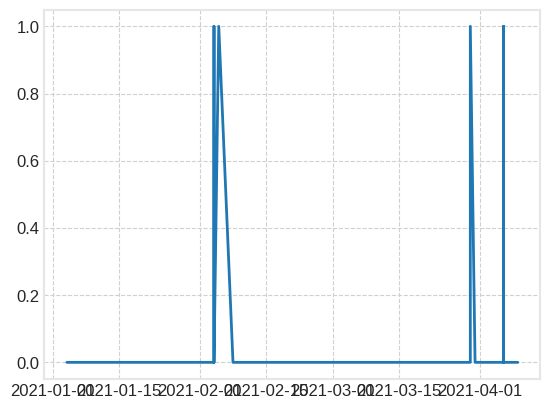

In [64]:
plt.plot(df['squeeze_on'])
plt.show()

In [59]:
df.index

DatetimeIndex(['2021-01-04', '2021-01-04', '2021-01-04', '2021-01-04',
               '2021-01-04', '2021-01-04', '2021-01-04', '2021-01-05',
               '2021-01-05', '2021-01-05',
               ...
               '2021-04-08', '2021-04-08', '2021-04-08', '2021-04-09',
               '2021-04-09', '2021-04-09', '2021-04-09', '2021-04-09',
               '2021-04-09', '2021-04-09'],
              dtype='datetime64[ns]', name='Date', length=469, freq=None)

In [60]:
df

,Open,High,Low,Close,Adj Close,Volume,20sma,stddev,lower_band,upper_band,TR,ATR,lower_keltner,upper_keltner,squeeze_on
Date,,,,,,,,,,,,,,,
2021-01-04,111.470001,114.099998,111.389999,113.639999,113.639999,4295047,NaN,NaN,NaN,NaN,2.709999,NaN,NaN,NaN,False
2021-01-04,113.641701,113.790001,111.400002,112.080002,112.080002,1654635,NaN,NaN,NaN,NaN,2.389999,NaN,NaN,NaN,False
2021-01-04,112.050003,112.070000,110.510101,110.845001,110.845001,910233,NaN,NaN,NaN,NaN,1.559898,NaN,NaN,NaN,False
2021-01-04,110.830002,112.238197,110.445000,112.238197,112.238197,1321199,NaN,NaN,NaN,NaN,1.793198,NaN,NaN,NaN,False
2021-01-04,112.199997,112.629997,111.750000,112.050003,112.050003,887042,NaN,NaN,NaN,NaN,0.879997,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-09,122.440002,122.949997,122.305000,122.849998,122.849998,489595,122.043430,1.217245,119.608941,124.477919,0.644997,0.832495,120.794687,123.292173,False
2021-04-09,122.839996,122.945000,122.610001,122.730003,122.730003,428970,122.056930,1.223589,119.609753,124.504107,0.334999,0.794745,120.864812,123.249048,False
2021-04-09,122.739998,122.849998,122.480003,122.517899,122.517899,618584,122.075825,1.227849,119.620127,124.531524,0.369995,0.771280,120.918905,123.232746,False


# Calculate DMI

In [ ]:
def di_plus(smoothed, DM)